# Exploratory Data Analysis
In this Exploratory Data Analysis Notebook we will look to the data, will analyze the content of dataset, understand the data distribution, check for missing data, handle outliers, see what are the relations between data in various files, feature engineering, etc.
## 1. Loading and Exploring Data
### 1.1 Loading libraries required and reading the data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import warnings
import matplotlib.pyplot as plt
import category_encoders as ce
import lightgbm as lgb
import copy
from scipy import stats
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate

from sklearn.ensemble import StackingClassifier
warnings.filterwarnings('ignore')

In [5]:
train_origin_df = pd.read_csv("./data/train.csv")
test_origin_df = pd.read_csv("./data/test.csv")
train_auxiliary_count_df = pd.read_csv('./data/auxiliary_count_train.csv')
test_auxiliary_count_df = pd.read_csv('./data/auxiliary_count_test.csv')
train_auxiliary_distance_df = pd.read_csv('./data/auxiliary-data/auxiliary-distance-amenties-train.csv')
test_auxiliary_distance_df = pd.read_csv('./data/auxiliary-data/auxiliary-distance-amenties-test.csv')
train_auxiliary_number_df = pd.read_csv('./data/auxiliary-data/auxiliary-number-amenties-train.csv')
test_auxiliary_number_df = pd.read_csv('./data/auxiliary-data/auxiliary-number-amenties-test.csv')
train_auxiliary_closeness_df = pd.read_csv('./data/auxiliary-data/weighted_closeness_amenties_train.csv')
test_auxiliary_closeness_df = pd.read_csv('./data/auxiliary-data/weighted_closeness_amenties_test.csv')
train_df = train_origin_df.merge(train_auxiliary_count_df, how='left', on='listing_id')
test_df = test_origin_df.merge(test_auxiliary_count_df, how='left', on='listing_id')

### 1.2 Data size and structure

In [5]:
print("The shape of train dataset is: ", train_df.shape)
print("The shape of test dataset is: ", test_df.shape)
train_df.head(3).append(train_df.tail(3))

The shape of train dataset is:  (20254, 26)
The shape of test dataset is:  (6966, 25)


listing_id                                              title  \
0          122881          hdb flat for sale in 866 yishun street 81   
1          259374  hdb flat for sale in 506b serangoon north aven...   
2          665422                 4 bed condo for sale in meyerhouse   
20251      928187  4 bed condo for sale in pullman residences newton   
20252      135122       hdb flat for sale in 691d woodlands drive 73   
20253      376579  4 bed condo for sale in pullman residences newton   

                                  address              property_name  \
0                sembawang / yishun (d27)       866 yishun street 81   
1      hougang / punggol / sengkang (d19)       hdb-serangoon estate   
2                          128 meyer road                 meyerhouse   
20251                     18 dunearn road  pullman residences newton   
20252         admiralty / woodlands (d25)            admiralty flora   
20253                     18 dunearn road  pullman residences newton   

      property_type             tenure  built_year  num_beds  num_baths  \
0       hdb 4 rooms                NaN      1988.0       3.0        2.0   
1               hdb  99-year leasehold      1992.0       4.0        2.0   
2             condo           freehold      2022.0       4.0        6.0   
20251         condo           freehold      2023.0       4.0        4.0   
20252   hdb 5 rooms  99-year leasehold      2017.0       3.0        2.0   
20253         condo           freehold      2023.0       4.0        4.0   

       size_sqft  ...         lng elevation          subzone  planning_area  \
0           1115  ...  103.837196         0     yishun south         yishun   
1           1575  ...  103.875625         0  serangoon north      serangoon   
2           3070  ...  103.895798         0      mountbatten  marine parade   
20251       1378  ...  103.836848         0         moulmein         novena   
20252       1205  ...  103.806671         0   woodlands east      woodlands   
20253       1378  ...  103.836848         0         moulmein         novena   

           price  count_commerical  count_mrt_station  count_primary  \
0       514500.0                 0                  1              3   
1       995400.0                 0                  0              3   
2      8485000.0                 0                  0              1   
20251  4193700.0                 1                  3              2   
20252   754800.0                 0                  1              3   
20253  4178000.0                 1                  3              2   

      count_secondary count_shopping  
0                   3              1  
1                   4              1  
2                   1              1  
20251               1              3  
20252               3              1  
20253               1              3  

[6 rows x 26 columns]

In [6]:
print(pd.DataFrame(train_df).dtypes)
pd.DataFrame(train_df).describe()

listing_id                int64
title                    object
address                  object
property_name            object
property_type            object
tenure                   object
built_year              float64
num_beds                float64
num_baths               float64
size_sqft                 int64
floor_level              object
furnishing               object
available_unit_types     object
total_num_units         float64
property_details_url     object
lat                     float64
lng                     float64
elevation                 int64
subzone                  object
planning_area            object
price                   float64
count_commerical          int64
count_mrt_station         int64
count_primary             int64
count_secondary           int64
count_shopping            int64
dtype: object


listing_id    built_year      num_beds     num_baths     size_sqft  \
count   20254.000000  19332.000000  20174.000000  19820.000000  2.025400e+04   
mean   550763.206428   2010.833695      3.122931      2.643542  1.854364e+03   
std    258874.420108     15.822803      1.281658      1.473835  1.354343e+04   
min    100043.000000   1963.000000      1.000000      1.000000  0.000000e+00   
25%    326279.000000   2000.000000      2.000000      2.000000  8.070000e+02   
50%    551397.000000   2017.000000      3.000000      2.000000  1.119000e+03   
75%    774044.500000   2023.000000      4.000000      3.000000  1.528000e+03   
max    999944.000000   2028.000000     10.000000     10.000000  1.496000e+06   

       total_num_units           lat           lng  elevation         price  \
count     14602.000000  20254.000000  20254.000000    20254.0  2.025400e+04   
mean        376.253938      1.434282    103.855356        0.0  5.228263e+06   
std         346.882474      1.558472      3.593441        0.0  2.779748e+08   
min           4.000000      1.239621    -77.065364        0.0  0.000000e+00   
25%         106.000000      1.307329    103.806576        0.0  8.190000e+05   
50%         296.000000      1.329266    103.841552        0.0  1.680000e+06   
75%         561.000000      1.372461    103.881514        0.0  3.242400e+06   
max        2612.000000     69.486768    121.023232        0.0  3.924243e+10   

       count_commerical  count_mrt_station  count_primary  count_secondary  \
count      20254.000000       20254.000000   20254.000000     20254.000000   
mean           0.213834           2.003654       1.790757         1.549570   
std            0.444905           2.503912       1.557141         1.390975   
min            0.000000           0.000000       0.000000         0.000000   
25%            0.000000           0.000000       0.000000         0.000000   
50%            0.000000           1.000000       2.000000         1.000000   
75%            0.000000           3.000000       3.000000         3.000000   
max            3.000000          16.000000       9.000000         7.000000   

       count_shopping  
count    20254.000000  
mean         2.492298  
std          3.574491  
min          0.000000  
25%          0.000000  
50%          1.000000  
75%          3.000000  
max         21.000000

As we can see from the data description, there are some outliers in 'lat', 'lng', 'price', 'size_sqft' variables, which we will handling later.

## 2. Exploring some of the most important variables
### 2.1 The target variable: price

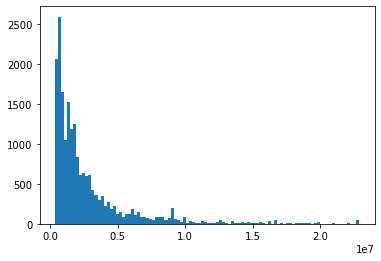

In [14]:
plt.hist(train_df['price'], range = (np.percentile(train_df['price'],1), np.percentile(train_df['price'],99)), bins=100)
plt.show()

In [15]:
#skewness and kurtosis
print("Skewness: %f" % train_df['price'].skew())
print("Kurtosis: %f" % train_df['price'].kurt())

Skewness: 139.161390
Kurtosis: 19609.020838


### 2.2 The most important numeric predictors
Since the categorical variables need some preprocess before we can use then, we decided to first see the relationships between numeric variables and the target varaible. It seems that 'lng', 'lat', 'size_sqft', 'price' variables contain outliers.

array([[<AxesSubplot:title={'center':'listing_id'}>,
        <AxesSubplot:title={'center':'built_year'}>,
        <AxesSubplot:title={'center':'num_beds'}>],
       [<AxesSubplot:title={'center':'num_baths'}>,
        <AxesSubplot:title={'center':'size_sqft'}>,
        <AxesSubplot:title={'center':'total_num_units'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'elevation'}>],
       [<AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

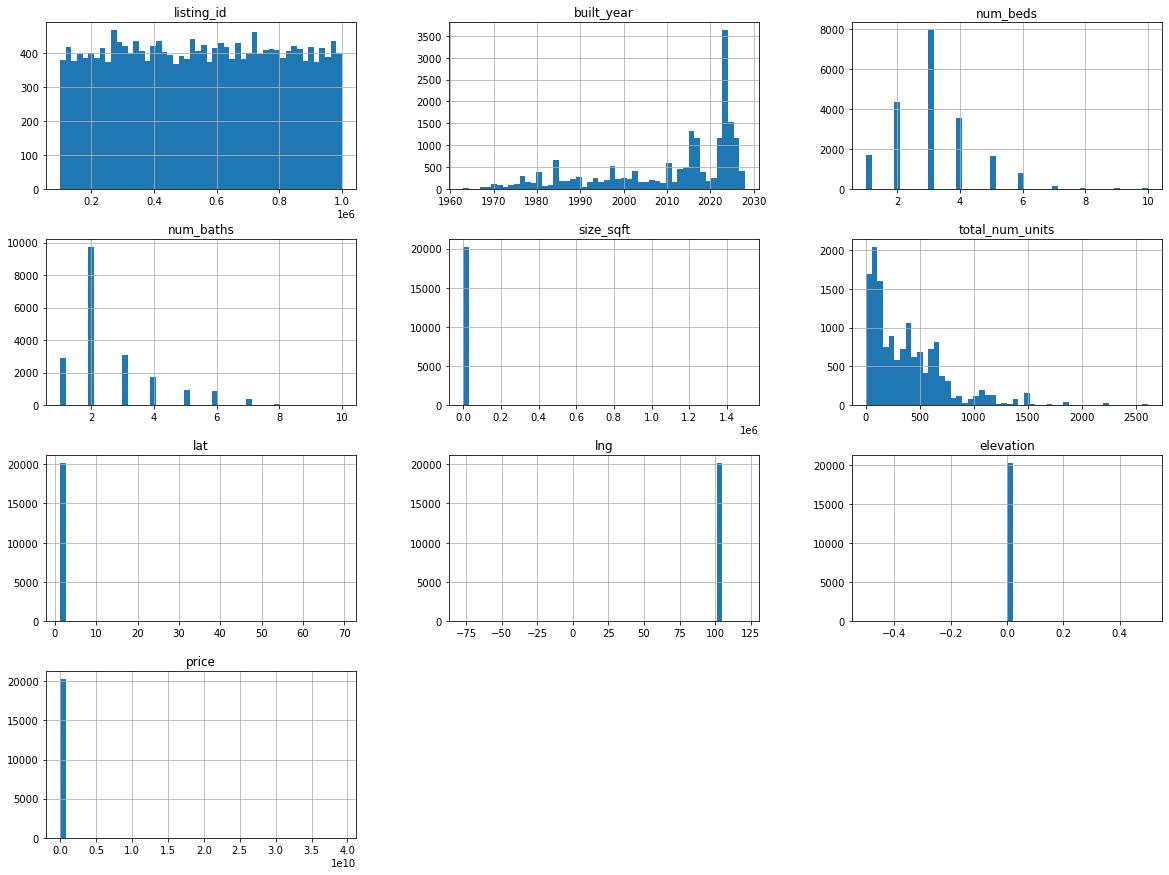

In [16]:
train_df.hist(bins=50, figsize=(20,15))

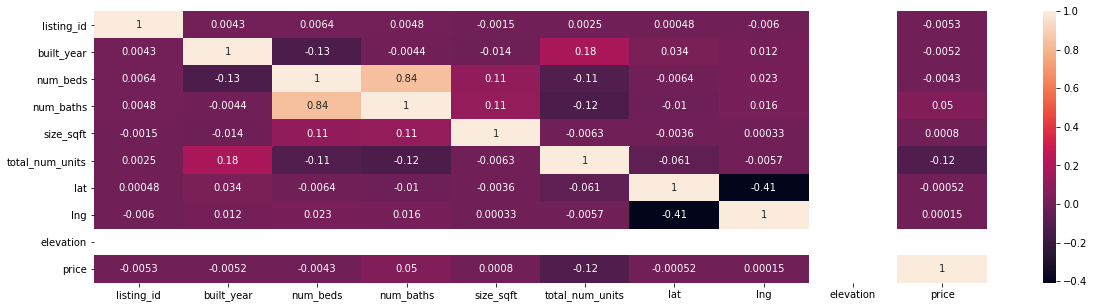

In [17]:
corr_matrix = train_df.corr()
plt.figure(figsize = (20,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

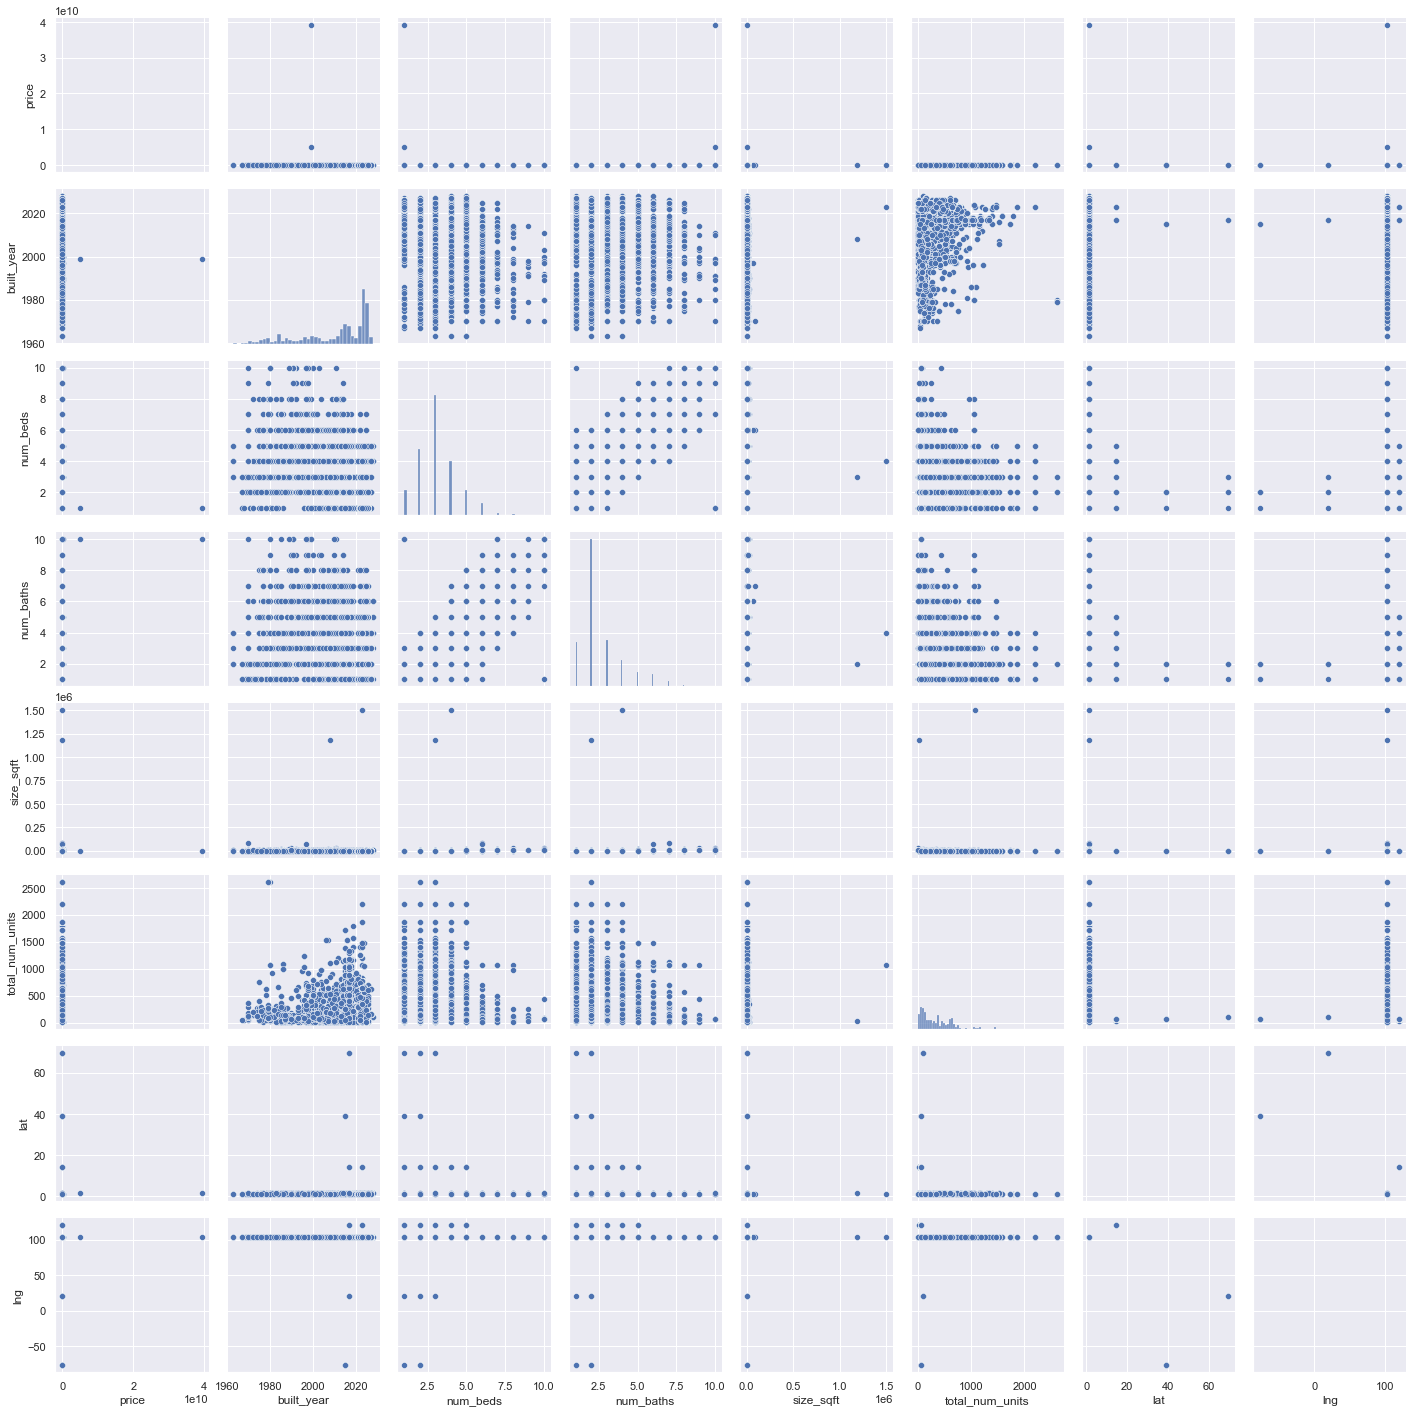

In [18]:
key_cols = ['price', 'built_year', 'num_beds', 'num_baths', 'size_sqft', 'total_num_units', 'lat', 'lng']
sns.set()
sns.pairplot(train_df[key_cols], height = 2.5)
plt.show()

## 3. Data Cleaning and Preprocessing
### 3.1 Missing Values
#### 3.1.1 Completeness of the data
First of all ,we would like to check which variables contain missing values.

In [4]:
total = train_df.isna().sum().sort_values(ascending=False)
percent = train_df.isna().sum()/(train_df.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys =['Total', 'Percent'])
missing_data

Total   Percent
floor_level           16746  0.826800
total_num_units        5652  0.279056
tenure                 1723  0.085070
available_unit_types   1441  0.071146
built_year              922  0.045522
num_baths               434  0.021428
planning_area           113  0.005579
subzone                 113  0.005579
num_beds                 80  0.003950
elevation                 0  0.000000
lng                       0  0.000000
lat                       0  0.000000
property_details_url      0  0.000000
listing_id                0  0.000000
furnishing                0  0.000000
title                     0  0.000000
size_sqft                 0  0.000000
property_type             0  0.000000
property_name             0  0.000000
address                   0  0.000000
price                     0  0.000000

#### 3.1.2 Handling missing data
- `tenure`:  Filled by the average value of same 'property_name'.
- `built_year`: Filled by the average value of same 'property_name'.
- `num_beds`: delete missing data.
- `num_baths`: imputing missing data based on 'num_beds', since the correlation coefficient between 'NUM_beds' and' NUM_baths 'is 0.84
- `floor_level`: drop feature.
- `total_num_units`: Filled by the average value of same 'property_name'.
- `subzone`: delete missing data. The latitude and longitude coordinates corresponding to the missing values are outliers, so the missing values cannot be filled in by calculation.
- `planning_area`: delete missing data. The latitude and longitude coordinates corresponding to the missing values are outliers, so the missing values cannot be filled in by calculation.

In [7]:
train_data=train_df.copy()
print("Before data cleanning, we have {} record".format(len(train_data)))

def compute_mean_map(df, col_A, col_B):
    """
        Compute missing values of a columns based on the average of flag_feature
    """ 
    AB = df.groupby([col_A], as_index=False)[col_B].mean()
    AB_map = dict(zip(AB[col_A], AB[col_B]))
    return AB_map

def computing_mode_by_neighbor(df, col_A, col_B):
    """
        Compute missing values of a columns based on resorted and 'ffill' method
    """ 
    df = df.sort_values(by=col_A)
    df[col_B] = df[col_B].fillna(method ='ffill')
    df = df.sort_index(axis=0)
    df[col_B].fillna(value = df[col_B].mode()[0], inplace=True)
    return df

# Impute "tenure" missing data by mean value of each "property" group
train_data = computing_mode_by_neighbor(train_data, 'property_name', 'tenure')

# Impute "built_year" missing data by mean value of each "property" group
property_year_map = compute_mean_map(train_df,'property_name', 'built_year')
train_data['built_year'].loc[train_data.built_year.isna()] = train_data.loc[train_data.built_year.isna(), :].apply(lambda x: property_year_map[x['property_name']], axis=1)
train_data['built_year'].fillna(value = np.mean(train_data['built_year']), inplace=True) # mismatched type

# Impute "total_num_units" missing data by mean value
property_unit_map = compute_mean_map(train_df, 'property_name', 'total_num_units')
train_data['total_num_units'].loc[train_data.total_num_units.isna()] = train_data.loc[train_data.total_num_units.isna(), :].apply(lambda x: property_unit_map[x['property_name']], axis=1)
train_data['total_num_units'].fillna(value = np.mean(train_data['total_num_units']), inplace=True) # mismatched type

#Delete missing data
missing_cols = ['num_beds', 'subzone', 'planning_area']
train_data.dropna(subset =missing_cols , axis=0, inplace=True)

# Drop 'floor_level' feature
train_data.drop(columns=['floor_level'], axis=1, inplace=True)

# Impute 'num_baths' missing data by mean value of the same "num_beds"
bath_bed_map = compute_mean_map(train_df, 'num_beds', 'num_baths')
train_data['num_baths'].loc[train_data.num_baths.isna()] = train_data.loc[train_data.num_baths.isna(), :].apply(lambda x: bath_bed_map[x['num_beds']], axis=1)

train_data.reset_index(drop=True, inplace=True)
print("After data cleanning, we have {} record".format(len(train_data)))
train_data.head(3)

Before data cleanning, we have 20254 record
After data cleanning, we have 20061 record


listing_id                                              title  \
0      122881          hdb flat for sale in 866 yishun street 81   
1      259374  hdb flat for sale in 506b serangoon north aven...   
2      665422                 4 bed condo for sale in meyerhouse   

                              address         property_name property_type  \
0            sembawang / yishun (d27)  866 yishun street 81   hdb 4 rooms   
1  hougang / punggol / sengkang (d19)  hdb-serangoon estate           hdb   
2                      128 meyer road            meyerhouse         condo   

              tenure  built_year  num_beds  num_baths  size_sqft  ...  \
0           freehold      1988.0       3.0        2.0       1115  ...   
1  99-year leasehold      1992.0       4.0        2.0       1575  ...   
2           freehold      2022.0       4.0        6.0       3070  ...   

          lng elevation          subzone  planning_area      price  \
0  103.837196         0     yishun south         yishun   514500.0   
1  103.875625         0  serangoon north      serangoon   995400.0   
2  103.895798         0      mountbatten  marine parade  8485000.0   

   count_commerical  count_mrt_station count_primary count_secondary  \
0                 0                  1             3               3   
1                 0                  0             3               4   
2                 0                  0             1               1   

   count_shopping  
0               1  
1               1  
2               1  

[3 rows x 25 columns]

### 3.2 Duplicated data
No duplicated data in the dataset.

In [8]:
print("The duplicated number of training data is {}.".format(train_df.duplicated().sum()))
print("The duplicated number of testing data is {}.".format(test_df.duplicated().sum()))

The duplicated number of training data is 0.
The duplicated number of testing data is 0.


### 3.3 Outliers
- `'lng'`: -77.065364, 20.1844341
- `'lat'`: 14.4848138, 38.9427759, 69.4867678
- `'size_sqft'`: 0, 1185000, 1496000
- `'furnishing'`: 'na'
- `'price'`: 0, 39242425300, 4985918600

In [9]:
# Delete outliers
train_data.drop(train_data[(train_data['price']==0)| (train_data['price'] > 120000000)].index, inplace=True)
train_data.drop(train_data[(train_data['size_sqft']==0)| (train_data['size_sqft'] > 100000)].index, inplace=True)
train_data.drop(train_data[(train_data['lat']>2)].index, inplace=True)
train_data.drop(train_data[(train_data['lng']<103)| (train_data['lng'] > 104)].index, inplace=True)
train_data['furnishing'].mask(train_data.furnishing =='na', other = 'unspecified', inplace=True)

train_data.reset_index(drop=True, inplace=True)
train_data.head()

listing_id                                              title  \
0      122881          hdb flat for sale in 866 yishun street 81   
1      259374  hdb flat for sale in 506b serangoon north aven...   
2      665422                 4 bed condo for sale in meyerhouse   
3      857699               3 bed condo for sale in leedon green   
4      216061                 2 bed condo for sale in one bernam   

                              address         property_name property_type  \
0            sembawang / yishun (d27)  866 yishun street 81   hdb 4 rooms   
1  hougang / punggol / sengkang (d19)  hdb-serangoon estate           hdb   
2                      128 meyer road            meyerhouse         condo   
3                   26 leedon heights          leedon green         Condo   
4                     1 bernam street            one bernam         condo   

              tenure  built_year  num_beds  num_baths  size_sqft  ...  \
0           freehold      1988.0       3.0        2.0       1115  ...   
1  99-year leasehold      1992.0       4.0        2.0       1575  ...   
2           freehold      2022.0       4.0        6.0       3070  ...   
3           freehold      2023.0       3.0        2.0        958  ...   
4  99-year leasehold      2026.0       2.0        1.0        732  ...   

          lng elevation          subzone  planning_area      price  \
0  103.837196         0     yishun south         yishun   514500.0   
1  103.875625         0  serangoon north      serangoon   995400.0   
2  103.895798         0      mountbatten  marine parade  8485000.0   
3  103.803271         0     farrer court    bukit timah  2626000.0   
4  103.843635         0            anson  downtown core  1764000.0   

   count_commerical  count_mrt_station count_primary count_secondary  \
0                 0                  1             3               3   
1                 0                  0             3               4   
2                 0                  0             1               1   
3                 0                  2             0               0   
4                 0                  3             1               0   

   count_shopping  
0               1  
1               1  
2               1  
3               1  
4               1  

[5 rows x 25 columns]

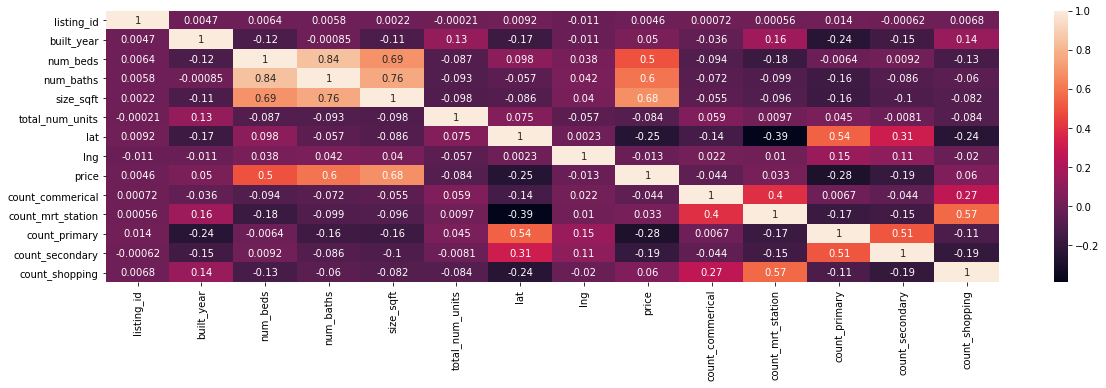

In [10]:
corr_matrix = train_data.drop(columns=['elevation']).corr()
plt.figure(figsize = (20,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

## 4. Feature Engineering

### 4.1 Feature Extraction and Transformation
Create and transform features based on our domain knowledge.

In [11]:
def match_tenure(x):
    if x == 'freehold':
        return 'freehold'
    if int(x)<120:
        return '99-year leasehold'
    elif int(x)<1000:
        return '999-year leasehold'
    else:
        return 'error'
    
train_data['property_type'] = train_data['property_type'].str.lower()
train_data['tenure'] = train_data['tenure'].map(lambda x: match_tenure(x.split('-')[0]))

### 4.2 Feature Encoding
- **One-hot encoding**: furnishing、property_type、tenure

- **target encoding**: subzone, planning_area

In [12]:
# One-hot encoding
encoding_list = ['furnishing', 'property_type', 'tenure']
train_numeric = train_data.drop(encoding_list, axis=1)

encoder = OneHotEncoder(categories='auto')
train_labels = encoder.fit_transform(train_data[encoding_list])
train = np.hstack((train_numeric.values, train_labels.toarray()))
train_columns = list(train_numeric.columns) + list(encoder.get_feature_names(encoding_list))
train = pd.DataFrame(train, columns=train_columns)

# Target encoding for 'subzone' and 'planning area'
planning_encoder= ce.TargetEncoder(cols='planning_area')
subzone_encoder = ce.TargetEncoder(cols='subzone') 
train['planning_area'] = planning_encoder.fit_transform(train_data[['planning_area']],train_data['price'])
train['subzone'] = subzone_encoder.fit_transform(train_data[['subzone']],train_data['price'])

### 4.3 Feature Selection
- **Remove "unimportant" features based on domain knowledge:** 'listing_id', 'title', 'address', 'property_name', 'property_details_url'
- **Remove features with very low variance:** ‘elevation’
- **Remove features that are strongly correlated with other features:** 'num_baths'

In [13]:
# feature selection
deleted_features = ['listing_id', 'title', 'address', 'property_name', 'property_details_url',
                   'elevation', 'available_unit_types','num_baths', ]
data = train.drop(columns=deleted_features, axis=1)
x = data.drop(columns=['price'],axis=1)
y = data['price']

### 4.4 Feature Normalization
Normalize features by standard normalization.

In [14]:
# Feature Normalization
scaler_std = StandardScaler()
x = scaler_std.fit_transform(x)

## 5. Modeling
### 5.1 LassoCV

In [20]:
# construct pipeline
pipe_lm = Pipeline([
        ('lasso_regr', LassoCV(alphas=(list(np.arange(8, 10) * 10)),
                                cv=KFold(n_splits=3, shuffle=True),
                                n_jobs=2))
        ])
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']
scores = cross_validate(pipe_lm, x, y, cv=5, scoring=scoring)
rmse = scores['test_neg_root_mean_squared_error'].mean()
mse = scores['test_neg_mean_absolute_error'].mean()
r2 = scores['test_r2'].mean()
# model performance
print(f'5-fold mean squared error is: {rmse}')
print(f'5-fold mean absolute error is: {mse}')
print(f'5-fold R Squared is: {r2}')

5-fold mean squared error is: -3104816.2946945922
5-fold mean absolute error is: -1029458.6801858094
5-fold R Squared is: 0.6032220042016021


## 5.3 RandomForest + GridSearch

In [ ]:
param_grid = [
    {'n_estimators': range(5, 71, 5), 'min_samples_split' :range(10,50,10), 
     'max_depth':[4,6,8,10]}
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x, y)
grid_search.best_estimator_

## 5.3 XGBRegressor

In [22]:
# construct pipeline
pipe_xgboost = Pipeline([
        ('xgb_model', XGBRegressor(n_estimators=1500, max_depth=7, eta=0.05, subsample=0.9, colsample_bytree=0.9))
        ])

scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']
scores = cross_validate(pipe_xgboost, x, y, cv=5, scoring=scoring)
rmse = scores['test_neg_root_mean_squared_error'].mean()
mse = scores['test_neg_mean_absolute_error'].mean()
r2 = scores['test_r2'].mean()
# model performance
print(f'5-fold mean squared error is: {rmse}')
print(f'5-fold mean absolute error is: {mse}')
print(f'5-fold R Squared is: {r2}')

5-fold mean squared error is: -1994138.2943002463
5-fold mean absolute error is: -328345.8571930786
5-fold R Squared is: 0.8337949365236531


## 6. Model Selection
we select xgboost with paramters n_estimators=1500, max_depth=7, eta=0.05, subsample=0.9, colsample_bytree=0.9 as our best model.

In [23]:
# construct pipeline
pipe_xgboost = Pipeline([
        ('xgb_model', XGBRegressor(n_estimators=1500, max_depth=7, eta=0.05, subsample=0.9, colsample_bytree=0.9))
        ])

# model performance
pipe_xgboost.fit(x,y)

Pipeline(steps=[('xgb_model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9, early_stopping_rounds=None,
                              enable_categorical=False, eta=0.05,
                              eval_metric=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.0500000007, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=7, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1500, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0, ...))])

## 7. Prediction
### 7.1 Test data preprocessing

In [24]:
test_data = copy.deepcopy(test_df)
test_fillvalues = {"tenure": test_df['tenure'].mode()[0],
                  "built_year": test_df['built_year'].mode()[0],
                  "num_beds": test_df['num_beds'].mode()[0],
                  "num_baths": test_df['num_baths'].mode()[0],
                  "total_num_units": test_df['total_num_units'].mode()[0],
                   "subzone": "balestier",
                   "planning_area":"novena",
                  }

# Add auxiliary features
test_data = test_data.drop(columns=deleted_features+['floor_level'], axis=1)
test_data.fillna(value=test_fillvalues, inplace=True)

# feature engineering
test_data['property_type'] = test_data['property_type'].str.lower()
test_data['furnishing'].mask(test_data.furnishing == 'na', other =test_data['furnishing'].mode()[0], inplace=True)
test_data['tenure'] = test_data['tenure'].map(lambda x: match_tenure(str(x).split('-')[0]))

# one-hot encoding 
test_numeric = test_data.drop(encoding_list, axis=1)
test_labels = encoder.transform(test_data[encoding_list])
test = np.hstack((test_numeric.values, test_labels.toarray()))
test_columns = list(test_numeric.columns) + list(encoder.get_feature_names(encoding_list))
test_x = pd.DataFrame(test, columns=test_columns)

# label encoding
test_x['planning_area'] = planning_encoder.transform(test_data[['planning_area']])
test_x['subzone'] = subzone_encoder.transform(test_data[['subzone']])

# scaler
X_test = scaler_std.transform(test_x)

test_x

built_year num_beds size_sqft total_num_units       lat         lng  \
0        2022.0      1.0       463           250.0  1.344334   103.87869   
1        2017.0      3.0      1033           463.0  1.380281  103.943878   
2        2007.0      1.0       570           646.0  1.294668  103.850074   
3        2017.0      3.0      1216           968.0   1.37312  103.746094   
4        1973.0      3.0       936           250.0  1.341468  103.849047   
...         ...      ...       ...             ...       ...         ...   
6961     2009.0      5.0      8000            29.0  1.249534  103.844281   
6962     2010.0      5.0      6974           250.0  1.332492  103.800004   
6963     2025.0      3.0      1141           376.0  1.294106  103.836735   
6964     1975.0      3.0       818           250.0  1.303736  103.911438   
6965     2023.0      3.0      1507           455.0   1.30277  103.869435   

           subzone  planning_area count_commerical count_mrt_station  ...  \
0     2.094450e+06   3.701766e+06                0                 3  ...   
1     2.135351e+06   2.727216e+06                0                 0  ...   
2     1.698901e+06   2.216876e+06                1                12  ...   
3     6.665613e+05   7.639835e+05                0                 0  ...   
4     9.198407e+05   1.501378e+06                1                 2  ...   
...            ...            ...              ...               ...  ...   
6961  1.522314e+07   1.522314e+07                0                 0  ...   
6962  1.058588e+07   5.647702e+06                0                 2  ...   
6963  3.902399e+06   5.169261e+06                0                 2  ...   
6964  2.942314e+06   4.165337e+06                0                 0  ...   
6965  3.177249e+06   2.227747e+06                0                 4  ...   

     property_type_land only property_type_landed  \
0                        0.0                  0.0   
1                        0.0                  0.0   
2                        0.0                  0.0   
3                        0.0                  0.0   
4                        0.0                  0.0   
...                      ...                  ...   
6961                     0.0                  0.0   
6962                     0.0                  0.0   
6963                     0.0                  0.0   
6964                     0.0                  0.0   
6965                     0.0                  0.0   

     property_type_semi-detached house property_type_shophouse  \
0                                  0.0                     0.0   
1                                  0.0                     0.0   
2                                  0.0                     0.0   
3                                  0.0                     0.0   
4                                  0.0                     0.0   
...                                ...                     ...   
6961                               0.0                     0.0   
6962                               1.0                     0.0   
6963                               0.0                     0.0   
6964                               0.0                     0.0   
6965                               0.0                     0.0   

     property_type_terraced house property_type_townhouse  \
0                             0.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   
...                           ...                     ...   
6961                          0.0                     0.0   
6962                          0.0                     0.0   
6963                          0.0                     0.0   
6964                          0.0                     0.0   
6965                          0.0                     0.0   

    

### 7.2 Output prediction result

In [25]:
test_y = pipe_xgboost.predict(X_test)
result = pd.DataFrame({"Id": np.arange(len(test_y)), "Predicted": test_y })
result.to_csv("test_predictions.csv",index=False, sep=',')